# Table of Contents
___

1. <a href='#overview_destination'>Overview</a>
2. <a href='#source_data_destination'>Source Data</a>
3. <a href='#getting_data_destination'>Getting Data</a>
4. <a href='#cleaning_destination'>Cleaning Data</a>
5. <a href='#eda_destination'>EDA</a>
6. <a href='#modelling_destination'>Modelling</a>
7. <a href='#recommender_destination'>Building A Recommender</a>
8. <a href='#explore_destination'>Explore Additional Models</a>
9. <a href='#summary_destination'>Summary</a>

<a id='overview_destination'></a>
## 1 Overview
___

Yelp is a service providing crowd-sourced reviews on businesses. The service offers both website and mobile app where users can leave photos together with comments regarding the services at these establishments.

This project tries to see if we can utilize the data available to make recommendation to users regarding restaurants listed on Yelp. I'm intersted in extracting cues regarding food taste of a user and 

There are many ways to build a recommender system. The planned methodology for this project is to use collaborative filtering, specifically matrix factorization, to make prediction of potential ratings of a user for a specific restaurant.

The modelling package is https://surprise.readthedocs.io/en/stable/

The Singular Value Decomposition:

$$\hat{r}_{ui}=\mu + {b}_{u} + {b}_{i} + {q}^{T}_{i}{p}_{u}$$

The cost function to optimize is:

$$\sum_{{r}_{ui}\in{R}_{train}}({r}_{ui}-\hat{r}_{ui})^2+\lambda({b}_{i}^2 + {b}_{u}^2 + ||{q}_{i}||^2 + ||{p}_{u}||^2)$$

<a id='source_data_destination'></a>
## 2 Source Data
___

The data are provided in different JSON files with the structures of:

1. Businesses

business_id | name | neighborhood | address | city | state | postal_cal | latitude | longitude | stars | review_count | is_open | categories | hours - Monday | hours - Tuesday | hours - Wednesday | hours - Thursday | hours - Friday | hours - Saturday | hours - Sunday | attributes - BikeParking | attributes - BusinessAcceptsCreditCards | attributes - BusinessParking | attributes - GoodForKids | attributes - HasTV | attributes - NoiseLevel | attributes - OutdoorSeating | attributes - RestaurantsAttire | attributes - RestaurantsDelivery | attributes - RestaurantsGoodForGroups | attributes - RestaurantsPriceRange2 | attributes - RestaurantsReservation | attributes - RestaurantsTakeOut
--- | --- | --- | --- | --- | --- |--- | --- | --- |--- | --- | --- |--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
Apn5Q_b6Nz61Tq4XzPdf9A | Minhas Micro Brewery | 1314 44 Avenue NE | Calgary | AB | T2E 6L6 | 51.0918130155 | -114.031674872 | 4 | 24 | 1 | Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel | 8:30-17:0 | 11:0-21:0 | 11:0-21:0 | 11:0-21:0 | 11:0-21:0 | 11:0-21:0 | | False | True | {'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False} | True | True | average | False | casual | False | True | 2 | True | True 

2. Users

user_id | name | review_count | yelping_since | friends | useful | funny | cool | fans | elite |  average_stars | compliment_hot | compliment_more | compliment_profile | compliment_cute | compliment_list | compliment_note | compliment_plain | compliment_cool | compliment_funny | compliment_writer | compliment_photos
--- | --- | --- | --- | --- |--- | --- | --- | --- | --- | --- 
lzlZwIpuSWXEnNS91wxjHw | Susan | 1 | 2015-09-28 | None | 0 | 0 | 0 | 0 | None | 2 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

3. Reviews

review_id | user_id | business_id | stars | date | text | useful | funny | cool
--- | --- | --- | --- | --- |--- | --- | --- | --- 
x7mDIiDB3jEiPGPHOmDzyw | msQe1u7Z_XuqjGoqhB0J5g | iCQpiavjjPzJ5_3gPD5Ebg | 2 | 2011-02-25 | The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo / Fort Apache. The chef there can make a MUCH better NY style pizza. The pizzeria @ Cosmo was over priced for the quality and lack of personality in the food. Biaggio's is a much better pick if youre going for italian - family owned, home made recipes, people that actually CARE if you like their food. You dont get that at a pizzeria in a casino. I dont care what you say... | 0 | 0 | 0

In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import seaborn as sns
import string
import scipy
import requests
from datetime import datetime
from tqdm import tqdm

from math import pi

import bokeh
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import cumsum

import surprise
from surprise import Reader, Dataset, SVD, SVDpp, KNNWithMeans, NMF
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from sklearn.metrics.pairwise import cosine_similarity, paired_cosine_distances
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

! python -m spacy download en
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

%matplotlib inline
plt.style.use('fivethirtyeight')

output_notebook()

Loading BokehJS ...

### 2-2 Loading Files

The files are big hence I stored them in Google Storage and queried them over to this compute engine hosting my notebook server.

In [2]:
# Only run this once

# !gsutil -m cp gs://staging.jl07-firstproj.appspot.com/data/yelp_academic_dataset_user.json /home/p_duongthai/capstone/data
# !gsutil -m cp gs://staging.jl07-firstproj.appspot.com/data/yelp_academic_dataset_business.json /home/p_duongthai/capstone/data
# !gsutil -m cp gs://staging.jl07-firstproj.appspot.com/data/yelp_academic_dataset_review.json /home/p_duongthai/capstone/data        

<a id='getting_data_destination'></a>
## 3 Getting Data
___
### 3-1 Getting a dictionary of cuisines

#### Call Yelp Fusion API To Get Categories

In [3]:
# API stuff
key = 't6XLHJ_Kyeo6GZh4C-D6jM3czFtX5SB30kDvg9mLLFcUfrxeQrgRHVswfH7u7HIug-GogsFY_3m4MAS9K47VkSEmIRUysZ36P8EpMv9NB6EtW2WsWusVLMdv7hgEXHYx'

client = 'mKtLQA7xq986f6W4ObeKjQ'

api_host = 'https://api.yelp.com'
category_path = '/v3/categories/{}'
all_categories_path = '/v3/categories'

url_params = {}
all_url = f'{api_host}{all_categories_path}'

headers = {
    'Authorization': f'Bearer {key}',
}

yelp_response = requests.request('GET', all_url, headers=headers, params=url_params)

categories_json = yelp_response.json()

In [4]:
restaurants_dict = {}
# we chose restaurant due to "business knowledge" --> restaurant categories look more like cuisine than food cats

# loop first time to get level 1 cats under Restaurant tag
for category in categories_json['categories']:
    if 'restaurants' in category['parent_aliases']:
        restaurants_dict.update({category['alias']:category['title']})
        
restaurants_l2_dict = {}        
# loop second time to get level 2 for all cats under Restaurant tag
# do this to simplify the nested categories

for category in categories_json['categories']:
    if len(category['parent_aliases'])>0 and set(category['parent_aliases']).issubset(list(restaurants_dict.keys())):
#         restaurants_dict.update({category['alias']:category['title']})
        restaurants_l2_dict.update({category['title']:category['parent_aliases']})

### 3-2 Utility Functions

In [5]:
def split_to_list(status):
    if status == 'None' or status is None:
        return []
    else:
        return [i.lstrip().strip() for i in status.split(',')]

In [6]:
# custom function to check if a category is in prescribed list

def is_food(res_categories):
    
    l1_cats_ls = []
    
    is_restaurant = False
    is_cat_l1 = False
    is_cat_l2 = False
    # if it has the word Restaurants
    if len(list(set(res_categories) & set(['Restaurants']))) >= 1:
        is_restaurant = True
    if len(list(set(res_categories) & set(list(restaurants_dict.values())))) >= 1:
        is_cat_l1 = True
    if len(list(set(res_categories) & set(list(restaurants_l2_dict.keys())))) >= 1:
        is_cat_l2 = True
        
    # remember: purpose is to get all to level 1 of Restaurants hence l2 dict store l2 title + parent alias ~ l1 alias
    if is_cat_l2:
        for item in res_categories:
            if restaurants_l2_dict.get(item,-1) != -1:
                
                l1_cats_ls.append(restaurants_dict.get(restaurants_l2_dict.get(item)[0])[0])
    if is_cat_l1:
        for item in res_categories:
            # this take care of others L1 which may present in the tags as well
            if (item not in l1_cats_ls) and (item in list(restaurants_dict.values())):
                l1_cats_ls.append(item)
    return l1_cats_ls if len(l1_cats_ls) != 0 else None

### 3-3 Loading Data

In [7]:
data_dir = 'data/'

In [8]:
# reading reviews

review_file = glob.glob(data_dir+'yelp_academic_dataset_review.json')
reviews_ls = []

with open(review_file[0]) as reviews_file:   
    for line in reviews_file:
        reviews_ls.append(json.loads(line))

In [9]:
reviews_df = pd.DataFrame(reviews_ls)

print(reviews_df.columns)
display(reviews_df.dtypes)
print(reviews_df.shape)

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')


business_id    object
cool            int64
date           object
funny           int64
review_id      object
stars           int64
text           object
useful          int64
user_id        object
dtype: object

(5996996, 9)


In [10]:
# reading businesses from file

businesses_file = glob.glob(data_dir+'yelp_academic_dataset_business.json')
businesses_ls = []

with open(businesses_file[0]) as businesses_file:   
    for line in businesses_file:
        businesses_ls.append(json.loads(line))

In [11]:
businesses_df = pd.DataFrame(businesses_ls)

print(businesses_df.columns)
display(businesses_df.dtypes)
print(businesses_df.shape)

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state'],
      dtype='object')


address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open           int64
latitude        float64
longitude       float64
name             object
neighborhood     object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

(188593, 15)


In [12]:
# reading user file

users_file = glob.glob(data_dir+'yelp_academic_dataset_user.json')
users_ls = []

with open(users_file[0]) as users_file:   
    for line in users_file:
        users_ls.append(json.loads(line))

In [13]:
users_df = pd.DataFrame(users_ls)

print(users_df.columns)
display(users_df.dtypes)
print(users_df.shape)

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful',
       'user_id', 'yelping_since'],
      dtype='object')


average_stars         float64
compliment_cool         int64
compliment_cute         int64
compliment_funny        int64
compliment_hot          int64
compliment_list         int64
compliment_more         int64
compliment_note         int64
compliment_photos       int64
compliment_plain        int64
compliment_profile      int64
compliment_writer       int64
cool                    int64
elite                  object
fans                    int64
friends                object
funny                   int64
name                   object
review_count            int64
useful                  int64
user_id                object
yelping_since          object
dtype: object

(1518169, 22)


<a id='cleaning_data_destination'></a>
# 4 Cleaning Data
___

In [14]:
reviews_df.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [15]:
# date in reviews_df needs to be converted to date type

reviews_df['date']= pd.to_datetime(reviews_df['date'])

/home/p_duongthai/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


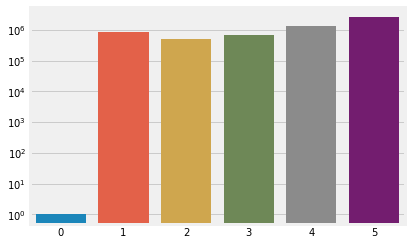

In [16]:
ratings_classes, ratings_counts = np.unique(reviews_df['stars'].values,return_counts=True)

sns.barplot(ratings_classes, ratings_counts)
plt.yscale('log')
plt.show()

That's strange, there is only 1 review with 0 star. Let's remove that.

In [17]:
reviews_df.drop(reviews_df[reviews_df['stars']==0].index,inplace=True)

In [18]:
display(businesses_df.isnull().sum())

address             0
attributes      25786
business_id         0
categories        541
city                0
hours           44802
is_open             0
latitude            6
longitude           6
name                0
neighborhood        0
postal_code         0
review_count        0
stars               0
state               0
dtype: int64

The records with missing attributes or categories are most troublesome. Let's see what we can do about them.

In [19]:
print(businesses_df[businesses_df['attributes'].isnull()]['categories'].unique())

['Insurance, Financial Services'
 'Financial Services, Check Cashing/Pay-day Loans, Title Loans'
 'Fast Food, Burgers, Restaurants' ...
 'Pet Groomers, Pets, Veterinarians, Pet Sitting, Pet Services'
 'Auto Repair, Used Car Dealers, Automotive'
 "Fashion, Women's Clothing, Accessories, Bridal, Shopping"]


Look like there are some food-related businesses in the bunch so we can't drop these records! Given the large number of records, let's just remove those without categories instead!

In [20]:
businesses_df.dropna(subset=['categories'], inplace=True)

In [21]:
print(users_df.isnull().sum())

average_stars         0
compliment_cool       0
compliment_cute       0
compliment_funny      0
compliment_hot        0
compliment_list       0
compliment_more       0
compliment_note       0
compliment_photos     0
compliment_plain      0
compliment_profile    0
compliment_writer     0
cool                  0
elite                 0
fans                  0
friends               0
funny                 0
name                  0
review_count          0
useful                0
user_id               0
yelping_since         0
dtype: int64


<a id='eda_destination'></a>
# 5 EDA
___

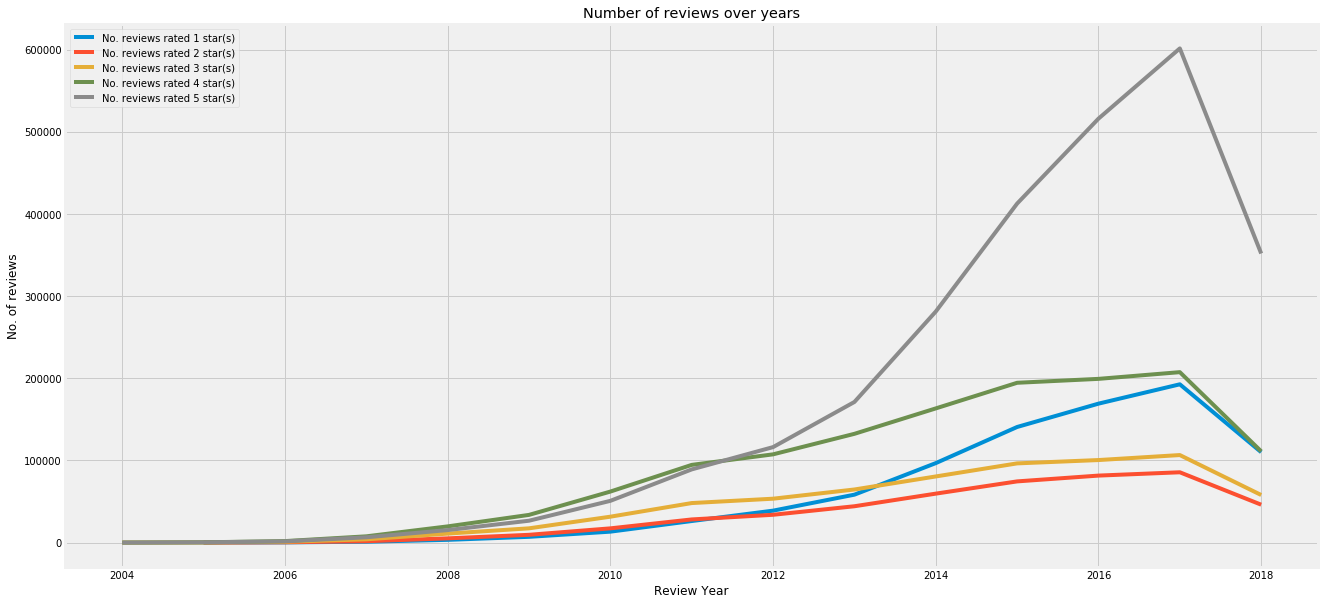

In [22]:
star_by_year_df = reviews_df.groupby([reviews_df['stars'],reviews_df['date'].dt.year]).count()[['review_id']]

plt.figure(figsize=(20,10))
for star in star_by_year_df.index.levels[0]:
    star_df = star_by_year_df.loc[star]
    sns.lineplot(x=star_df.index,y='review_id',data=star_df,label=f'No. reviews rated {star} star(s)')
plt.legend(loc=0,prop={'size': 10})
plt.xlabel('Review Year')
plt.ylabel('No. of reviews')
plt.title(f'Number of reviews over years')
# plt.savefig(fname='reviews_year')
plt.show()

In [23]:
status_dict = {}
for status in users_df['elite'].unique():
    for stat in status.split(','):
        if stat.lstrip().strip() in status_dict:
            status_dict[stat.lstrip().strip()] += 1
        else:
            status_dict[stat.lstrip().strip()] = 1

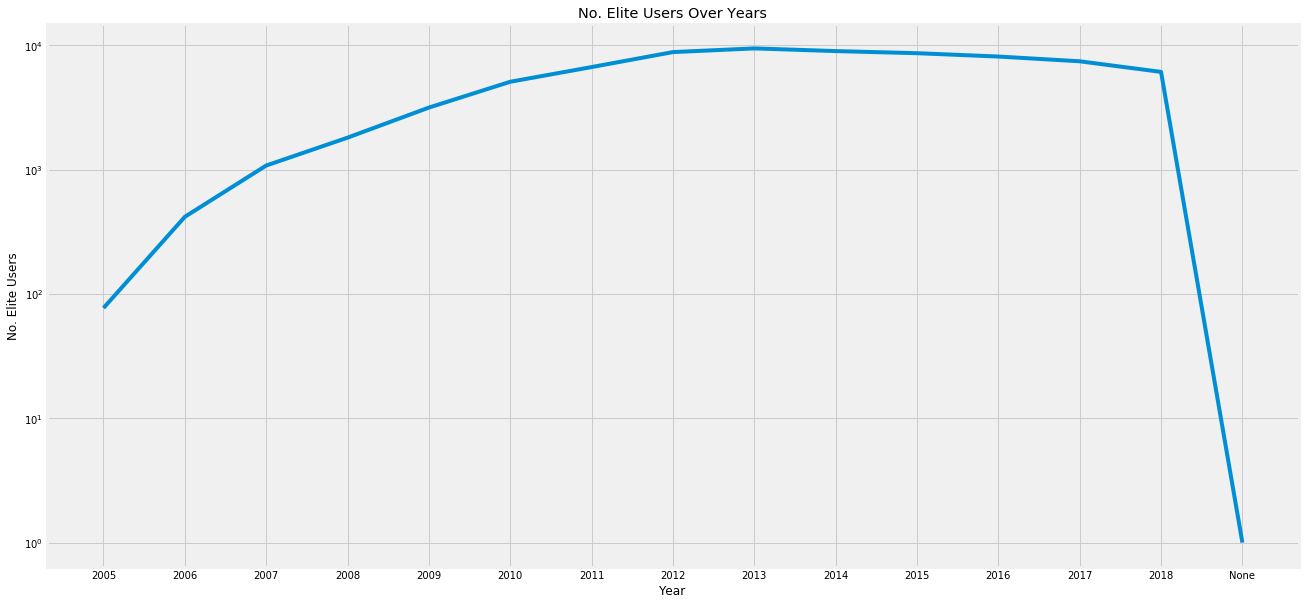

In [24]:
plt.figure(figsize=(20,10))
sns.lineplot(x=[*status_dict.keys()], y=[*status_dict.values()])
plt.title('No. Elite Users Over Years')
plt.xlabel('Year')
plt.ylabel('No. Elite Users')
plt.yscale('log')
plt.show()

On Yelp, to maintain an Elite status, an account has to actively engage with the platform: generate new review, leaves comments or reactions at other reviews, receiving reactions from other users. And the status is reviewed annually. As a user was continuously tagged as Elite, a new year would be added to his/her profile. Based on the number of times a year appeared in unique combinations, Yelp appears to garner most users during the 2012-2014 period and saw and steady decline ever since.

In [25]:
display(businesses_df.categories)

0         Tours, Breweries, Pizza, Restaurants, Food, Ho...
1         Chicken Wings, Burgers, Caterers, Street Vendo...
2         Breakfast & Brunch, Restaurants, French, Sandw...
3                             Insurance, Financial Services
4         Home & Garden, Nurseries & Gardening, Shopping...
5                                        Coffee & Tea, Food
6                                            Food, Bakeries
7                                         Restaurants, Thai
8                                      Mexican, Restaurants
9                     Flowers & Gifts, Gift Shops, Shopping
10                                    Restaurants, Japanese
11                      Cajun/Creole, Southern, Restaurants
12        Bars, Sports Bars, Dive Bars, Burgers, Nightli...
13           Restaurants, Pakistani, Indian, Middle Eastern
14                                   Beauty & Spas, Barbers
15                           Delis, Restaurants, Sandwiches
16        Nightlife, Bars, American (Tra

In [26]:
businesses_df['categories_ls'] = list(map(split_to_list,businesses_df['categories']))

categories_dict = {}
for categories in businesses_df['categories_ls']:
    for category in categories:
        if category in categories_dict:
            categories_dict[category] += 1
        else:
            categories_dict[category] = 1

categories_keys = categories_dict.keys()
categorie_dict_df = pd.DataFrame(list(zip(list(categories_keys),
                                          list(categories_dict[i] for i in categories_keys))),
                                 columns=['category','frequency'])

categorie_dict_df.sort_values(by=('frequency'),ascending=False)

,category,frequency
3,Restaurants,57173
21,Shopping,30231
4,Food,27118
41,Beauty & Spas,18967
53,Home Services,18634
63,Health & Medical,16157
22,Local Services,12906
23,Automotive,12656
37,Nightlife,12438
34,Bars,10853


I'm surprised that Yelp has a lot of businesses under Shopping or other categories and not entirely just restaurants!

We first want to see if for each business, can one user_id only give 1 rating?

In [27]:
reviews_inter_cnt_df = reviews_df[['business_id','user_id','review_id']].groupby(by=['user_id','business_id']).review_id.count()
reviews_dup = reviews_inter_cnt_df[reviews_inter_cnt_df>1].index.tolist()

In [28]:
for item in reviews_dup:
    display(reviews_df[(reviews_df['user_id']==item[0]) & (reviews_df['business_id']==item[1])])

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
4591943,V_oOjMVRXnr_t_9i1CSivw,0,2016-08-26,0,I8v-5jfkBluyN5kT8ha0bA,5,I had someone give me a facial and ruined my f...,0,8GpM-QUlb0V9DP56Xse3EA
4591944,V_oOjMVRXnr_t_9i1CSivw,0,2016-07-09,1,6vc4tqVh9_tbMRtFeS4pIw,5,I had someone give me a facial and ruined my f...,2,8GpM-QUlb0V9DP56Xse3EA


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
2055037,xKQVtEWiPK6hq0DljVnAfg,0,2017-05-02,0,1l-mU-BwQsZRW7BKdHVwZw,1,"This place continues to be a shit hole, with P...",0,XNzChtoNOw706kps82x0Kg
2055038,xKQVtEWiPK6hq0DljVnAfg,0,2015-02-06,0,IcpPtd37iJEthZybuasS4g,1,My mother recently spent a good deal of time i...,8,XNzChtoNOw706kps82x0Kg


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
5154279,7MacgLhLGiXvZoZdhgeKPw,1,2017-06-03,0,HFgn9Wz2jydIZLtqUeGu0Q,5,I always stop by DFEF for my morning fix every...,0,lLF9x4I41LFFKa_FX-lkbQ
5154280,7MacgLhLGiXvZoZdhgeKPw,0,2017-01-03,0,HR1JWyemX-kmNFaQ5LxR2g,5,I always stop by DFEF for my morning fix every...,1,lLF9x4I41LFFKa_FX-lkbQ


These reviews seem to be updated reviews (surprisingly). To take care of these very minor scenarios, we can take the latest of the timestamp columns).

In [29]:
reviews_df = reviews_df[reviews_df.groupby(by=['user_id','business_id'])['date'].transform(max) == reviews_df['date']]

print(reviews_df.shape)

no_total_reviews = reviews_df.shape[0]

(5996992, 9)


## 5-1 Understanding Restaurants' Categories

My premise is only modelling restaurants and will utilize cuisines. Looking at the values of categories under Food and Restaurant, only those under Restaurant are cuisine-like (Food values look more like dishes). Additionally, there are nested levels for categories in Restaurant as well. We need to find a way to untangle them.

For the simplicity of analysis, I will only take a look at first sub-category and convert those values at second sub-category level into their parents.

In [30]:
# let's apply our utility function to distill the food-only categories

businesses_df['simplify_cats'] = list(map(is_food,businesses_df['categories_ls']))

# after this, we will 

restaurants_df = businesses_df[~businesses_df['simplify_cats'].isnull()]

In [31]:
print(len(restaurants_df))

56281


In [32]:
reviews_food_only_df = reviews_df.merge(restaurants_df[['business_id','name']], on=['business_id'], how='left')

reviews_df = reviews_food_only_df[~reviews_food_only_df['name'].isnull()]

reviews_df['review_year'] = reviews_df['date'].dt.year

reviews_df['review_month'] = reviews_df['date'].dt.year

print(reviews_df.shape)
no_cuisine_reviews = reviews_df.shape[0]

/home/p_duongthai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(3622981, 12)


/home/p_duongthai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Awesome, we managed to remove the three cases we identified above!

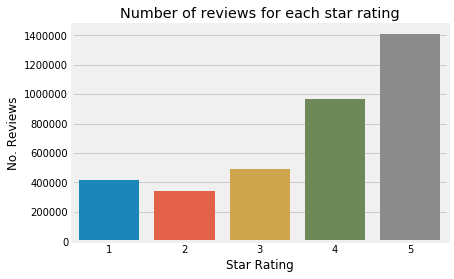

In [33]:
sns.barplot(reviews_df.groupby('stars').count()['review_id'].index,reviews_df.groupby('stars').count()['review_id'].values)
plt.title("Number of reviews for each star rating")
plt.xlabel('Star Rating')
plt.ylabel("No. Reviews")
plt.show()

The set has an imbalanced no. reviews for 5-star rated records.

In [34]:
# Let's plot a pie chart in bokeh!
x = {
    'Cuisine-Related Reviews': no_cuisine_reviews,
    'Other Reviews': no_total_reviews-no_cuisine_reviews,
}

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'review_type'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = ['coral','royalblue'] #Category20c[len(x)]

piechart = figure(plot_height=350, title="Pie Chart - Number of reviews", toolbar_location=None,
           tools="hover", tooltips="@review_type: @value", x_range=(-0.5, 1.0), )

piechart.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='review_type', source=data)

piechart.axis.axis_label=None
piechart.axis.visible=False
piechart.grid.grid_line_color = None

show(piechart)

In [36]:
ratings_users_ls = reviews_df[['user_id','business_id','stars']]['user_id'].unique()
ratings_businesses_ls = reviews_df[['user_id','business_id','stars']]['business_id'].unique()

business_ls = restaurants_df['business_id'].values
total_users_ls = users_df['user_id'].values

print(f'Total No. of users without any reviews {len(total_users_ls)-len(ratings_users_ls)}')
print(f'Total No. of businesses without any reviews {len(business_ls)-len(ratings_businesses_ls)}')

Total No. of users without any reviews 492968
Total No. of businesses without any reviews 0


That's so many "inactive" users!

In [35]:
print(f'Median no. reviews is {np.median(np.array((reviews_df.groupby("user_id")["review_id"].count())))}')
print(f'Mean no. reviews is {np.mean(np.array((reviews_df.groupby("user_id")["review_id"].count())))}')

Median no. reviews is 1.0
Mean no. reviews is 3.533922616150394


The median number of reviews is only 1 per user! This is a very very sparse matrix of user ratings/businesses. This will present a serious cold start problem when we look at finding similarity among users.

In [289]:
group_cnt_df = reviews_df.groupby('user_id').count().reset_index()[['user_id','review_id']]

In [460]:
group_cnt_df['review_id'].describe()

count    1.025201e+06
mean     3.533923e+00
std      1.055567e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.300000e+03
Name: review_id, dtype: float64

There are user(s) with 2300 reviews?! Let's see that

In [291]:
group_cnt_df[group_cnt_df['review_id']==2300].index

Int64Index([223372], dtype='int64')

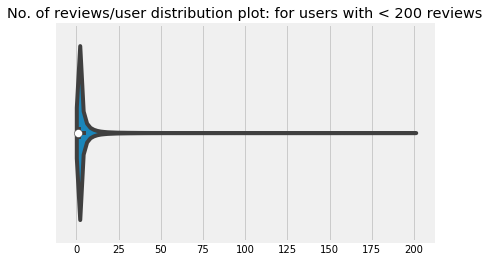

In [295]:
sns.violinplot(group_cnt_df.drop(group_cnt_df[group_cnt_df['review_id']>200].index)['review_id'].values)
plt.title('No. of reviews/user distribution plot: for users with < 200 reviews')
plt.show()

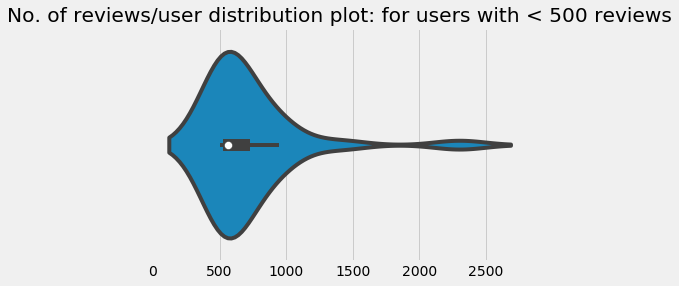

In [458]:
sns.violinplot(group_cnt_df.drop(group_cnt_df[group_cnt_df['review_id']<500].index)['review_id'].values)
plt.title('No. of reviews/user distribution plot: for users with < 500 reviews')
plt.show()

<a id='modelling_destination'></a>
# 6 Modelling
___

## 6-1 Approach 1 - Matrix Factorization User-Restaurant

In [55]:
reader = Reader(rating_scale=(1, 5))

ratings_food_df = reviews_df[reviews_df['review_year']==2016][['user_id', 'business_id', 'stars']] # treat this as test set

ratings_surprise_df = Dataset.load_from_df(ratings_food_df, reader)

In [457]:
baseline_rec = BaselineOnly()
surprise.model_selection.cross_validate(baseline_rec, ratings_surprise_df, measures=['RMSE','MAE'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (6.613567352294922,
  6.64941143989563,
  7.338420629501343,
  6.692265033721924,
  7.398461103439331),
 'test_mae': array([1.06090451, 1.05854392, 1.05823521, 1.05518913, 1.05931052]),
 'test_rmse': array([1.29865051, 1.29820474, 1.29716665, 1.29194308, 1.2962783 ]),
 'test_time': (1.2925052642822266,
  1.249199628829956,
  1.2453241348266602,
  1.2598249912261963,
  1.1804664134979248)}

In [56]:
ratings_surprise_df.split(n_folds=5)

# cross validation
svd_model = SVD()
surprise.model_selection.cross_validate(svd_model, ratings_surprise_df, measures=['RMSE','MAE'])

{'fit_time': (39.63856482505798,
  39.406063079833984,
  39.63956117630005,
  39.27184319496155,
  39.02591896057129),
 'test_mae': array([1.0510261 , 1.05342884, 1.04994134, 1.05356744, 1.05406867]),
 'test_rmse': array([1.29728326, 1.29837626, 1.29332573, 1.29810879, 1.29798778]),
 'test_time': (2.8016927242279053,
  1.5213909149169922,
  1.4429700374603271,
  1.3969831466674805,
  1.364018440246582)}

In [60]:
# build another set for optimization
ratings_food15_df = reviews_df[reviews_df['review_year']==2015][['user_id', 'business_id', 'stars']] # treat this as test set

ratings_surprise15_df = Dataset.load_from_df(ratings_food15_df, reader)

In [92]:
# GridSearch for optimizing parameters

param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.001, 0.1],
              'reg_all': [0.4, 0.6, 0.1], 'n_factors': [100,110, 120, 130]}
svd_optimizer = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

svd_optimizer.fit(ratings_surprise15_df)

# best RMSE score
print(svd_optimizer.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_optimizer.best_params['rmse'])


1.2798189192969407
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'n_factors': 100}


In [ ]:
# GridSearch for optimizing parameters

param_grid2 = {'n_epochs': [5, 10, 20], 'lr_all': [0.005, 0.001, 0.1],
              'reg_all': [0.4, 0.6, 0.1], 'n_factors': [100,500,1000,2000]}
svd_optimizer2 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

svd_optimizer2.fit(ratings_surprise15_df)

# best RMSE score
print(svd_optimizer2.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_optimizer2.best_params['rmse'])


In [462]:
# best RMSE score
print(svd_optimizer2.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_optimizer2.best_params['rmse'])

1.2794708377674961
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'n_factors': 100}


Comparing RMSE, SVD model didn't perform really much better than the baseline predictor. The main culprit may be the sparsity of my dataset. We have ~5mil reviews where as there are 1.5mil users and ~155k restaurants. That's a very small % of my user-restaurant review matrix being filled. Hence, with SVD implementation, the influence of the matrix factorization will be harder to outweight the baseline predictor portion in the formula.

## 6-2 Approach 2 - Can We Combine Clustering and SVD?

### 6-2-1 Feature Engineering & Extraction

#### 6-2-1-1 Getting Price Range for the restaurants

In [62]:
# the attributes are buried inside nested json structure. Let's get them out and put them into a list.

restaurants_df['price_range'] = restaurants_df['attributes'].map(lambda x: x.get('RestaurantsPriceRange2',0) if x is not None else 0)

/home/p_duongthai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
restaurants_df['price_range'] = pd.to_numeric(restaurants_df['price_range'])

/home/p_duongthai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### 6-2-1-2 Compute the price range preference

In [64]:
price_reviews_df = reviews_df.merge(restaurants_df[['business_id','price_range']], 
                                           on='business_id')[['review_id','user_id','price_range']]
price_reviews_pivot_df = price_reviews_df.groupby(by=['user_id','price_range']).count()
price_reviews_pivot_df.reset_index(inplace=True)

In [65]:
price_reviews_matrix_df = pd.pivot_table(price_reviews_pivot_df, values='review_id',
                                         index='user_id',columns='price_range',aggfunc=sum)
price_reviews_matrix_df.reset_index(inplace=True)
print(price_reviews_matrix_df.shape)

(1025201, 6)


#### 6-2-1-3 Building Cuisine Preference

In [66]:
reviews_test_df = reviews_df[reviews_df['review_year'] == 2016][['user_id','business_id','review_id']]
restaurants_test_df = restaurants_df[['business_id','simplify_cats']]

In [67]:
cuisine_ratings_df = reviews_test_df.merge(restaurants_test_df, on='business_id', how='left')
cuisine_series = cuisine_ratings_df.apply(lambda x: 
                                          pd.Series(x['simplify_cats']), axis=1).stack().reset_index(level=1, drop=True)

In [68]:
cuisine_series.name='cuisine'
cuisine_update_df = cuisine_ratings_df.join(cuisine_series)
cuisine_update_df.reset_index(inplace=True)

In [69]:
cuisine_pref_matrix_df = cuisine_update_df[['user_id','review_id','cuisine']].pivot_table(values='review_id',
                                                                                          index='user_id', columns='cuisine', aggfunc='count')
cuisine_pref_matrix_df.fillna(0,inplace=True)
cuisine_pref_matrix_df.reset_index(inplace=True)

In [308]:
cuisine_pref_matrix_df.sample(5)

cuisine,user_id,A,Afghan,African,American (New),American (Traditional),Arabian,Argentine,Armenian,Asian Fusion,...,Thai,Traditional Norwegian,Turkish,Ukrainian,Uzbek,Vegan,Vegetarian,Vietnamese,Waffles,Wraps
198526,grSZCpMjEW9Ibt6z8NIw6Q,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
113457,Oc7FbZnzIj77bD8p2qyojg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199489,h4zY-bhSKlmt5abuDOnyvg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96434,KmP0bKPFrMxD1J0pD377dA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128463,S13cjAjHnY5kSxXsU2viQg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
users_total_reviews_df = cuisine_ratings_df.groupby('user_id').count()[['review_id']].reset_index()
# users_total_reviews_df.set_index('user_id', drop=True, inplace=True)

#### 6-2-1-4 Extract Users' Locations Based On Reviews

In [72]:
location_reviews_df = reviews_test_df.merge(restaurants_df[['business_id','city']],
                                              on='business_id')[['review_id','user_id','city']]
location_reviews_df2 = location_reviews_df.groupby(by=['user_id','city']).count().reset_index()
location_reviews_df2['ranking'] = location_reviews_df2.groupby('user_id')['review_id'].rank(ascending=False)

# since each user may review more than one locations, I assume the location with the most reviews is user's location

users_locations_all_df = users_df.merge(location_reviews_df2[location_reviews_df2['ranking']==1], on='user_id', how='left')

#### 6-2-1-5 Building Custom User Profile

Since we established that many of the users are very inactive, "cold start" problem. Let's exclude them from our dataset for modelling first.

In [145]:
users_id_df = users_df[['user_id']]
users_w_reviews_df = reviews_test_df[['user_id']]

active_users_df = users_id_df.merge(users_w_reviews_df, 
                                    on='user_id', how='inner')

active_w_price_df = active_users_df.merge(price_reviews_matrix_df, 
                                                      how='left', on='user_id')
users_profile_df = active_w_price_df.merge(users_total_reviews_df,  
                                           how='left', on='user_id')

In [146]:
users_profile_df.set_index('user_id',inplace=True)
users_profile_df.fillna(0,inplace=True)

In [147]:
users_profile_df.sample(10)

,0,1,2,3,4,review_id
user_id,,,,,,
xtnxQ-61hHrkYZ3fa8OCAg,0.0,5.0,10.0,0.0,0.0,2
dkGyxlhUrbsBJkZHZy9NZQ,0.0,3.0,8.0,1.0,0.0,3
C-ObuoSf6iXBnc0MgAJBrw,1.0,15.0,49.0,6.0,0.0,9
GXVEhnIM1CpiGj9TZehxGw,0.0,10.0,42.0,17.0,2.0,11
4jbz7cOVuV_Q7v2b3pNrLw,1.0,4.0,24.0,4.0,1.0,30
MyqN6E2yEZQ2QvBRAXNeGA,1.0,1.0,7.0,0.0,0.0,8
yjS3WsyxfLqURejnamV5UA,0.0,1.0,5.0,8.0,0.0,11
6neC-g0JasIqzgIS73t-Kg,0.0,0.0,2.0,1.0,0.0,3
7nA9P6EukhTwZi67JB-UTg,1.0,28.0,30.0,1.0,2.0,56


In [148]:
profile_pca = PCA(n_components=0.95)

users_profile_df_pca = profile_pca.fit_transform(users_profile_df)

print(profile_pca.explained_variance_ratio_)

[0.91979007 0.04232772]


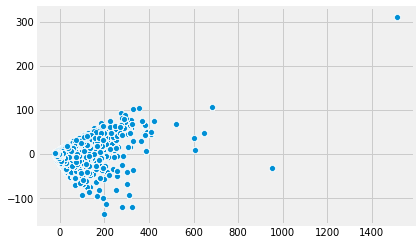

In [149]:
sns.scatterplot(x=users_profile_df_pca[:,0],y=users_profile_df_pca[:,1])
plt.show()

In [158]:
kmean_profile = KMeans()

kmean_profile.fit(users_profile_df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

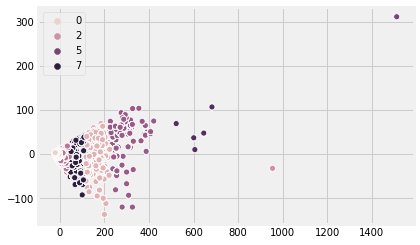

In [192]:
sns.scatterplot(x=users_profile_df_pca[:,0],y=users_profile_df_pca[:,1],hue=kmean_profile.labels_)
plt.show()

In [194]:
np.unique(kmean_profile.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([495848,  12024,    280,  88325,   4435,    139,    630,  34356]))

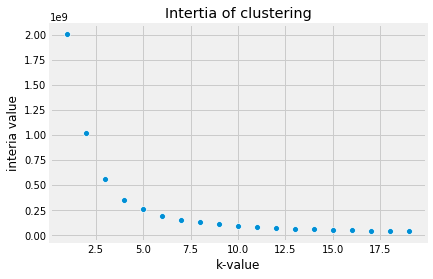

In [167]:
n_clusters = np.arange(1,20)

inertia_ls = []

for k in n_clusters:
    
    kmeans_model = KMeans(n_clusters = k)
    kmeans_model.fit(users_profile_df_pca)
    
    inertia_ls.append(kmeans_model.inertia_)
    
sns.scatterplot(n_clusters, inertia_ls)
plt.title("Intertia of clustering")
plt.xlabel("k-value")
plt.ylabel("interia value")
plt.show()

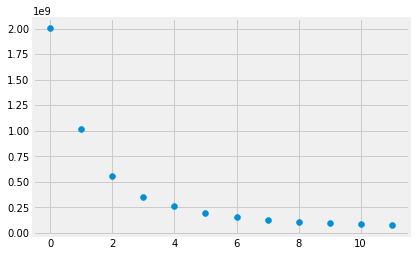

In [168]:
plt.scatter(np.arange(12),inertia_ls[0:12])
plt.show()

Looking at the elbow graph (and the zoomed in version), I can guess that after 7 clusters, there is not much inertia delta as the value of k increased. This can be my estimated number of clusters to construct a decent clustering model!

#### Combining Clustering and SVD

In [169]:
kmean_opt_profile = KMeans(n_clusters=7)

kmean_opt_profile.fit(users_profile_df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

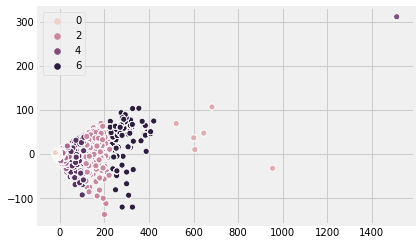

In [193]:
sns.scatterplot(x=users_profile_df_pca[:,0],y=users_profile_df_pca[:,1],hue=kmean_opt_profile.labels_)
plt.show()

In [195]:
np.unique(kmean_profile.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([495848,  12024,    280,  88325,   4435,    139,    630,  34356]))

In [171]:
# pick a random class to test

label_1_indices = np.where(kmean_opt_profile.labels_==1)[0].flatten()

In [172]:
# build users profile for these only

ratings_wkmeans_df = Dataset.load_from_df(ratings_food_df[['user_id', 'business_id', 'stars']].iloc[label_1_indices,:],
                                           reader)

In [173]:
#svd_opt_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.1, n_factors=100)
svd_test = SVD()
# rating_train, rating_test = train_test_split(ratings_surprise_df, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
# svd_opt_model.fit(rating_train)
# predictions = svd_opt_model.test(rating_test)

# Then compute RMSE
# accuracy.rmse(predictions)
ratings_wkmeans_df.split(n_folds=5)

# surprise.model_selection.cross_validate(svd_opt_model, ratings_wkmeans_df, measures=['RMSE','MAE'])
surprise.model_selection.cross_validate(svd_test, ratings_wkmeans_df, measures=['RMSE','MAE'])

{'fit_time': (0.047365665435791016,
  0.046085357666015625,
  0.04664158821105957,
  0.04629397392272949,
  0.045763254165649414),
 'test_mae': array([1.08612662, 1.0910086 , 1.09626749, 1.10403807, 1.04556583]),
 'test_rmse': array([1.32384594, 1.30996018, 1.36418377, 1.33146719, 1.31411493]),
 'test_time': (0.0014109611511230469,
  0.0015399456024169922,
  0.001363515853881836,
  0.0015382766723632812,
  0.0014119148254394531)}

In [174]:
svd_opt_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.1, n_factors=100)
# svd_test = SVD()
# rating_train, rating_test = train_test_split(ratings_surprise_df, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
# svd_opt_model.fit(rating_train)
# predictions = svd_opt_model.test(rating_test)

# Then compute RMSE
# accuracy.rmse(predictions)
ratings_wkmeans_df.split(n_folds=5)

surprise.model_selection.cross_validate(svd_opt_model, ratings_wkmeans_df, measures=['RMSE','MAE'])
# surprise.model_selection.cross_validate(svd_test, ratings_wkmeans_df, measures=['RMSE','MAE'])

{'fit_time': (0.04862213134765625,
  0.0470883846282959,
  0.04777336120605469,
  0.0459442138671875,
  0.04704475402832031),
 'test_mae': array([1.1161079 , 1.12794453, 1.11165284, 1.024278  , 1.04272101]),
 'test_rmse': array([1.38755092, 1.3623779 , 1.3684071 , 1.27753451, 1.24710964]),
 'test_time': (0.0018405914306640625,
  0.0015347003936767578,
  0.0014383792877197266,
  0.0014524459838867188,
  0.001493692398071289)}

The metrics we should track perform worse than purely using SVD!

<a id='recommender_destination'></a>
# Building The Recommender!

In [450]:
class Recommender():
    
    def __init__(self, model):
        self.message = 'Getting Prediction'
        self.model = model #SVD(n_epochs=20, lr_all=0.005, reg_all=0.1, n_factors=100)
        
    def get_location(self,obj_id, user_flag=1):
        if user_flag == 1:
            return users_locations_all_df[users_locations_all_df['user_id']==obj_id]['city'].values[0]
        else:
            return restaurants_df[restaurants_df['business_id']==obj_id]['city'].values[0]
    
    def get_restaurants(self,location):
        return restaurants_df[restaurants_df['city']==location]['business_id'].values
    
    def is_new_user(self,user_id):
        return user_id in reviews_df.user_id.values
    
    def get_actual_rating(self,user_id, restaurant_id):
        return reviews_df[(reviews_df['user_id']==user_id) & (reviews_df['business_id']==restaurant_id)]['stars'].values
    
    def get_top20_restaurants(self,user_id, user_location):
        local_restaurants = self.get_restaurants(user_location)
#         last_month, last_2_month = datetime.today().month-1, datetime.today().month-2
        last_two_months_revs = reviews_df[reviews_df['business_id'].isin(local_restaurants)]#.merge(local_restaurants, on='business_id', how='inner')
        return last_two_months_revs.sort_values(by=['stars'],ascending=False)['business_id'][:20].values
    
    def recommend_restaurant_search(self,user_id,restaurant_id):
        # to-do: replace with class.method to get user's location
        user_location = self.get_location(user_id)
        if pd.isnull(user_location):
            user_location = 'Toronto' #default value since we don't have mean to determine physical location
        if not self.is_new_user(user_id):
            top_20 = self.get_top20_restaurants(user_id,user_location)
            return restaurants_df[restaurants_df['business_id'].isin(top_20)]['name'] 
        else:
            predicted_rating = self.model.predict(user_id,restaurant_id).est
            actual_rating = self.get_actual_rating(user_id,restaurant_id)#self.model.predict(user_id,restaurant_id).r_ui
            was_impossible = self.model.predict(user_id,restaurant_id).details['was_impossible']
            
            #recommendation_mess = f'User {user_id} searched for restaurant {restaurants_df[restaurants_df["business_id"]==restaurant_id].name.values}. Predicted rating is {predicted_rating} and actual rating was {actual_rating}. Prediction was {"unsuccessful" if was_impossible else "successful"}'
            return user_id, restaurants_df[restaurants_df["business_id"]==restaurant_id].name.values, predicted_rating, actual_rating, "unsuccessful" if was_impossible else "successful" #recommendation_mess

## 6-3 Test With Full Set

### 6-3-1 Initialize full data set and fit model

In [315]:
test_reader = Reader(rating_scale=(1, 5))
overall_set_df = Dataset.load_from_df(reviews_df[['user_id','business_id','stars']], test_reader)

In [416]:
my_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.1, n_factors=100)
my_model.fit(overall_set_df.build_full_trainset())

### 6-3-2 Instantiate recommender object

In [451]:
my_recommender = Recommender(my_model)

### 6-3-3 Test single prediction

In [437]:
user_id, restaurant_name, predicted_rating, actual_rating, success = my_recommender.recommend_restaurant_search('n0r_0HkCFaC175vXtIVcaQ','RrCgc8eAKbHu-2IpQXg6Rw')
message = f'User {user_id} searched for restaurant {restaurant_name}. Predicted rating is {predicted_rating} and actual rating was {actual_rating}. Prediction was {success}'

In [438]:
print(message)

User n0r_0HkCFaC175vXtIVcaQ searched for restaurant ['Hiroba Sushi']. Predicted rating is 5 and actual rating was []. Prediction was successful


In [340]:
reviews_df[reviews_df['user_id']=='iy5nIOR6XiGgsAqUP2tpRw']

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,name,review_year,review_month
1321437,2VelfIojKVInFvEd-yMkww,0,2016-12-05,0,InS8sAgLLSjLFhXoD-lK-A,5,This is a place where I walk in and immediatel...,0,iy5nIOR6XiGgsAqUP2tpRw,Fiddler's Courtyard,2016,2016
1321438,XSZgcEMWM4XcuE-sWXny9w,0,2017-05-21,0,jTAGZ3fPD9ykq6Vczxj3rA,2,This review applies specifically to the roofto...,1,iy5nIOR6XiGgsAqUP2tpRw,Charbar,2017,2017
1321439,2AcO-aHnBqx94dU2Z4Em2Q,0,2017-02-19,1,lxiP5oFFJUnYlczlC8PB7A,1,After reading previous reviews of how good the...,7,iy5nIOR6XiGgsAqUP2tpRw,The Main Dish,2017,2017


### 6-3-4 Test recommendation list

In [369]:
calgary_restaurants = restaurants_df[restaurants_df['city']=='Calgary']['name'].values
calgary_restaurants.shape

(2757,)

In [358]:
predicted = []
actual = []

for restaurant in tqdm(calgary_restaurants):
    user_id, restaurant_name, predicted_rating, actual_rating, success = my_recommender.recommend_restaurant_search('iy5nIOR6XiGgsAqUP2tpRw',restaurant)
    predicted.append(predicted_rating)
    actual.append(actual_rating)

100%|██████████| 2757/2757 [1:09:54<00:00,  1.52s/it]


In [370]:
test_rated_df = pd.DataFrame({'restaurant': calgary_restaurants,
     'predicted_rating': predicted,
     'actual_rating': actual
    })

In [372]:
test_rated_df.sort_values(by=['predicted_rating'],ascending=False)

,actual_rating,predicted_rating,restaurant
2478,[],4.473537,European Bakery & Deli
1365,[],4.450064,Big Catch
723,[],4.443864,Veg-In YYC
2245,[],4.435162,Madras Cafe
2695,[],4.424780,Crispy Crust Pizza
1643,[],4.419245,Cafe Momoko
165,[],4.386906,Beirut Street Food
419,[],4.386583,Cafe Fresco
1663,[],4.360493,The Himalayan
2531,[],4.349191,Peppino


### 6-3-5 Test recommendation for new user (cold start)

In [387]:
no_reviews_users = users_df.merge(reviews_df, on='user_id', how='left')[['user_id','review_id']]

In [452]:
top_restaurants = my_recommender.recommend_restaurant_search('U2E4aVOe0WYm-aJdT5Syyw','RrCgc8eAKbHu-2IpQXg6Rw')

In [453]:
display(top_restaurants)

11072                 Donatello Restaurant
16251                         Banh Mi Boys
43923                          Tokyo Grill
55029                       Sansotei Ramen
62836                       Buca Yorkville
66478                  Film Cafe by Eative
71517              Prohibition Gastrohouse
82981     SCADDABUSH Italian Kitchen & Bar
85301                                Canoe
97230                             Bar Buca
104004                Montecito Restaurant
111111                           Gusto 101
113148                             Soufi's
116692                 The Burger's Priest
120073                El Catrin Destileria
128965                           Kasa Moto
131744                 Otto's Berlin Döner
140760                                Kiin
142545                       The Good Fork
Name: name, dtype: object

<a id='explore_destination'></a>
# 8 Explore Additional Models
___

## 8-1 Approach 2 - SVDpp

In [ ]:
cross_val_svdpp = SVDpp()
surprise.model_selection.cross_validate(cross_val_svdpp, ratings_surprise_df, measures=['RMSE','MAE'])

In [ ]:
# GridSearch for optimizing parameters

# opt_svdpp = SVDpp()

param_svdpp_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.007, 0.005, 0.001, 0.1],
              'reg_all': [0.4, 0.6, 0.1], 'n_factors': [15, 20, 25, 30]}
svdp_optimizer = GridSearchCV(SVDpp, param_svdpp_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

svdp_optimizer.fit(ratings_surprise15_df)

# best RMSE score
print(svdp_optimizer.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svdp_optimizer.best_params['rmse'])

## 8-2 Approach 3 - Co-Clustering

In [ ]:
test_cluster = CoClustering()
surprise.model_selection.cross_validate(test_cluster, ratings_surprise_df, measures=['RMSE','MAE'])

## 8-3 Approach 4 - NMF

In [ ]:
test_nmf = NMF()
surprise.model_selection.cross_validate(test_nmf, ratings_surprise_df, measures=['RMSE','MAE'])

In [ ]:
# GridSearch for optimizing parameters

param_nmf_grid = {'n_epochs': [45, 50, 55],
              'reg_pu': [0.06, 0.03, 0.05], 'reg_qi': [0.06, 0.03, 0.05], 'n_factors': [10, 15, 20, 25], 'biased': [False, True]}
nmf_optimizer = GridSearchCV(NMF, param_nmf_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

nmf_optimizer.fit(ratings_surprise15_df)

# best RMSE score
print(nmf_optimizer.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(nmf_optimizer.best_params['rmse'])

These methods took really long even on Google cloud to run during optimization steps. 

## 8-4 Experiment Text Review Analysis

In [297]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 2),
    max_features=30000)

In [298]:
# fit and transform on it the training features
word_vectorizer.fit(reviews_df[reviews_df['review_year']==2015]['text'])#[:8000])
reviews_x_features = word_vectorizer.transform(reviews_df[reviews_df['review_year']==2015]['text'])#[:8000])

In [299]:
reviews_x = reviews_df[reviews_df['review_year']==2015]['text']
reviews_y = reviews_df[reviews_df['review_year']==2015]['stars']

print(np.unique(reviews_y.values,return_counts=True))

print(reviews_x.shape, reviews_y.shape)

reviews_x_train, reviews_x_test, reviews_y_train, reviews_y_test = train_test_split(reviews_x, reviews_y, test_size=0.5, stratify=reviews_y)
print('train set', reviews_x_train.shape, reviews_y_train.shape)
print('test set', reviews_x_test.shape, reviews_y_test.shape)

(array([1, 2, 3, 4, 5]), array([ 67578,  52732,  72183, 144256, 223628]))
(560377,) (560377,)
train set (280188,) (280188,)
test set (280189,) (280189,)


In [305]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

class CleanTextTransformer(TransformerMixin):

    def transform(self, x, **transform_params):
        return [cleanText(text) for text in x]

    def fit(self, x, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [306]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('classifier', clf)])

pipe.fit(reviews_x_train, reviews_y_train)

reviews_lin_preds = pipe.predict(reviews_x_test)

print("linear accuracy:", accuracy_score(reviews_y_test, reviews_lin_preds))

linear accuracy: 0.5834133388534168


I realised that I was on a wrong path as text analysis should be done for the restaurants and find similar restaurants instead of modelling regression for text analysis and rating prediction.

<a id='summary_destination'></a>
# 9 Summary
___
The recommender system problem space has proven to be quite complex. There have been numerous researches done in this space, providing a wealth of approaches. In practice, recommender systems rely on combinations of various models/approaches to provide more reliable recommendations/predictions.

There are also engineering tasks involved to improve computation, thus timeliness of recommendation.

Another challenge is quality assessment of recommender system. Options range from A/B test, to expert survey, or customer feedback. Businesses want to improve both accuracy and novelty of recommendations.

If anything, this project proves the biggest challenge is to devise mechanisms which can overcome sparse matrix, store and process large amount of data, and computation speed.